# Machine Learning on Stock Time Series Data : Ebay and Yahoo

### Exploratory Data Analysis

We'll deal with stock market prices that fluctuate over time. In this project we've got historical prices from two tech companies (Ebay and Yahoo) in the DataFrame prices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/prices.csv", parse_dates=["date"], index_col="date")

EBAY = df[df["symbol"].isin(["EBAY"])].drop(["symbol","volume"], axis=1).rename(columns={"close": "EBAY"})
YHOO = df[df["symbol"].isin(["YHOO"])].drop(["symbol","volume"], axis=1).rename(columns={"close": "YHOO"})
prices = pd.concat([EBAY, YHOO], axis=1)
prices.head()

,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


Let us visualize the raw data for the two companies, through the line chart. It will show the general trend of the price movements of both companies

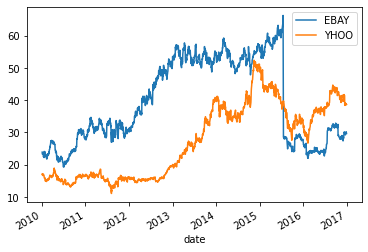

In [2]:
# Plot the raw values over time
prices.plot()
plt.show()

Now let us generate a scatter plot showing how the values for each company compare with one another. This is a way of using cluster analysis to understand where two companies form clusters and how close the clusters are.

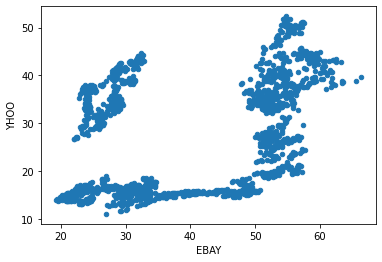

In [3]:
# Scatterplot with one company per axis
prices.plot.scatter("EBAY", "YHOO")
plt.show()

Finally, let us add in a "time" dimension to our scatter plot so that we can see how this relationship changes over time.

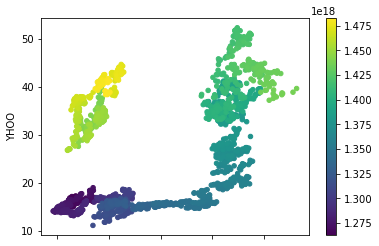

In [5]:
# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, 
                    cmap=plt.cm.viridis, colorbar=True)
plt.show()

Let us see if there is any missing values in the dataset

In [6]:
# Count the missing values of each time series
missing_values = prices.isnull().sum()
print(missing_values)

EBAY    0
YHOO    0
dtype: int64


### Wrangling and Transforming the raw data

Although we do not have missing data points, let us still write a helper function that may come in handy later when we will use other time series data that may contain missing values

Through this helper function, We will be using different interpolation methods to fill in some missing values, visualizing the result each time. 

In [8]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=True)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=True)
    plt.show()

Now let us test if this function works. Since our two dataset does not contain any missing values, it will appear in black line plot and there will not be any red points that may appear in the plot.

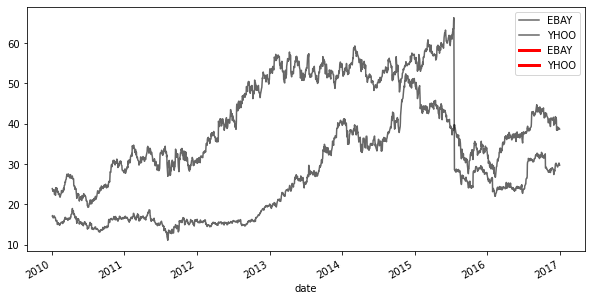

In [9]:
# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)

Let us use a different interpolation method, although we know that the result will be same

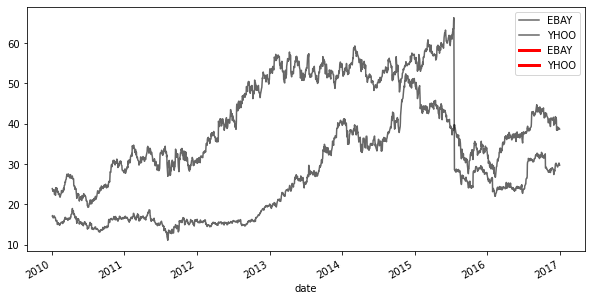

In [10]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices, interpolation_type)

Since we are working with two different time series, we need to settle on a common ground of truth for standardization of raw data. We can take for example percent change over a rolling window as common ground of standardization. This is a more stable kind of time series that is useful in machine learning. 

Here, we will define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help you calculate the percent change over a rolling window.

In [11]:
import numpy as np
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change


Now let us use this helper function to standardize the two time series and visualize them

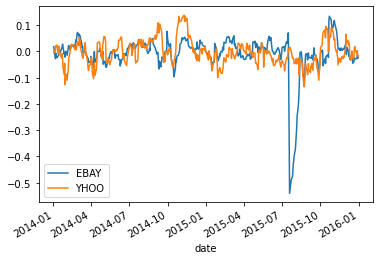

In [12]:

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

An alternative approach of doing something quite similar:

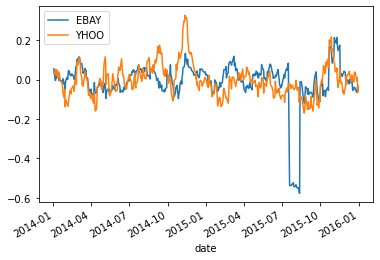

In [13]:
def pct_change(window):
    return (window[-1] - window[0]) / window[0]
# Apply your custom function and plot
another_prices_perc = prices.rolling(20).apply(pct_change)
another_prices_perc.loc["2014":"2015"].plot()
plt.show()

We can clearly see from the plot that there are some data points that are so different from the rest of your data, that we treat them differently from other "normal-looking" data points. We will now write a helper function that replaces outlier data points with the median value from the entire time series.

<AxesSubplot:xlabel='date'>

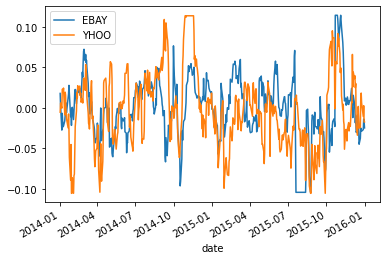

In [16]:
# Calculate the median
median = np.nanmedian(prices_perc2)
std = np.std(prices_perc2)
# Calculate the interquartile range (IQR)
Q1 = prices_perc2.quantile(0.25)
Q3 = prices_perc2.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# lower_bound = Q1 - 3 * std
# upper_bound = Q3 + 3 * std

# Replace outliers with the median
prices_perc2 = prices_perc2.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Plot the results
# prices_perc2.plot()
plt.show()

# prices_perc2 = prices_perc2.apply(lambda series: series.mask(np.abs(series - np.mean(series)) > 3 * np.std(series), np.mean(series)))
prices_perc2.loc["2014":"2015"].plot()
# plt.show()

We will use an alternative approach:

In [14]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series


Now let us apply this function to our dataset.

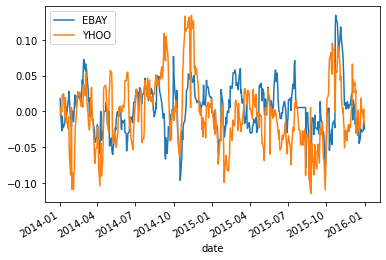

In [17]:

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

Now let's move on to something more complex feature engineering. We'll calculate a collection of features for our time series data and visualize what they look like over time. This process resembles how many other time series models operate.

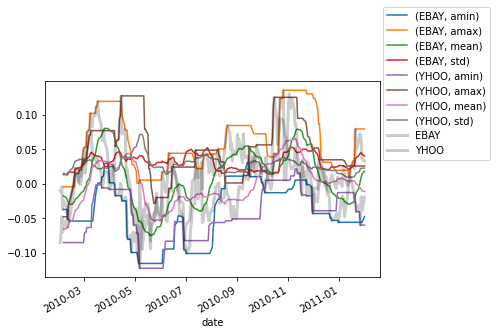

In [18]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.agg(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

We will also pre-choose arguments of a function so that we can pre-configure how it runs. We'll use this to calculate several percentiles of our data using the same `percentile()` function in numpy

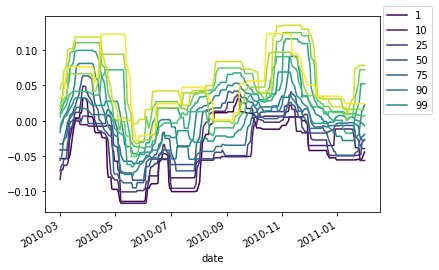

In [19]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = pd.concat([prices_perc_rolling.apply(func) for func in percentile_functions], axis=1)

# features_percentiles = prices_perc_rolling.agg(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

It's easy to think of timestamps as pure numbers, but in the real world there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data. We can create those information as new features that may aid us in machine learning algorithms

In [20]:
# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.day_of_week
prices_perc['week_of_year'] = prices_perc.index.weekofyear
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)

                EBAY      YHOO  day_of_week  week_of_year  month_of_year
date                                                                    
2010-01-04       NaN       NaN            0             1              1
2010-01-05       NaN       NaN            1             1              1
2010-01-06       NaN       NaN            2             1              1
2010-01-07       NaN       NaN            3             1              1
2010-01-08       NaN       NaN            4             1              1
...              ...       ...          ...           ...            ...
2016-12-23  0.024842 -0.038006            4            51             12
2016-12-27  0.038030 -0.027985            1            52             12
2016-12-28  0.026925 -0.029311            2            52             12
2016-12-29  0.021850 -0.028632            3            52             12
2016-12-30  0.007285 -0.026603            4            52             12

[1762 rows x 5 columns]


C:\Users\88016\AppData\Local\Temp/ipykernel_27156/1971407619.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  prices_perc['week_of_year'] = prices_perc.index.weekofyear


In [26]:

df = pd.read_csv("dataset/prices.csv", parse_dates=["date"], index_col="date")
EBAY = df[df["symbol"].isin(["EBAY"])].drop(["symbol","volume"], axis=1)
EBAY= EBAY.div(EBAY.iloc[0])
EBAY.head()

,close
date,
2010-01-04,1.000000
2010-01-05,0.989540
2010-01-06,0.983264
2010-01-07,0.971966
2010-01-08,0.983682


In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.

Here, we'll "shift" our raw data and visualize the results. We'll use the percent change time series that we calculated  with a very short window. A short window is important because, in a real-world scenario, we want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

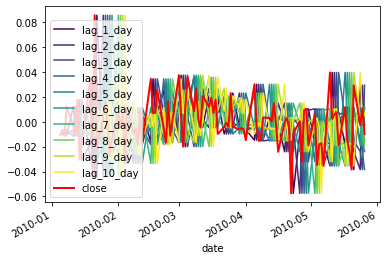

In [27]:
import numpy as np

prices_perc = EBAY['close'].pct_change()
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()